In [10]:
%%capture --no-stderr
%pip install --quiet -U langchain_groq langchain_core langgraph sentence-transformers

In [11]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"Greetings, traveler. You seek knowledge?", name="Oracle")]
messages.append(HumanMessage(content=f"Yes, I'm researching ancient civilizations.", name="Explorer"))
messages.append(AIMessage(content=f"A fascinating pursuit! What civilization piques your interest?", name="Oracle"))
messages.append(HumanMessage(content=f"Tell me about the construction of the Great Pyramid of Giza.", name="Explorer"))

for m in messages:
    m.pretty_print()


================================== Ai Message ==================================
Name: Oracle

Greetings, traveler. You seek knowledge?
================================ Human Message =================================
Name: Explorer

Yes, I'm researching ancient civilizations.
================================== Ai Message ==================================
Name: Oracle

A fascinating pursuit! What civilization piques your interest?
================================ Human Message =================================
Name: Explorer

Tell me about the construction of the Great Pyramid of Giza.


In [ ]:
import os


os.environ["GROQ_API_KEY"] = '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'

os.environ["LANGSMITH_API_KEY"] = 'ls__YOUR_LANGSMITH_API_KEY_HERE'
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy-groq" 

In [ ]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="moonshotai/kimi-k2-instruct") 
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [14]:
result

AIMessage(content='The Great Pyramid of Khufu (c. 2589–2566 BCE) is a 481-foot, 6.2-million-ton stack of 2.3 million limestone and granite blocks, most weighing 2–3 t and a few roofing-blocks in the “King’s Chamber” 60–80 t.  \nPrecision: base 230.4 m per side, deviation from level only 2 cm, mean deviation of sides from true cardinal 3′ 37″.  \nTool kit: chert (flint) and dolerite pounders, copper chisels (hardened by hammering and arsenic alloying), tubular copper-drills with quartz sand abrasive, granite saws with dolerite grit, and wooden sledges.  \nLabour: 5–7 000 skilled specialists (surveyors, masons, boat-crews, tool-smiths, scribes) + a rotating mass of c. 20 000 unskilled workmen; four “phyles” working three-month corvée shifts; total project 20–24 years.  \nLogistics:  \n– Quarries on-site for local limestone; Tura-Maasara fine limestone casing 12 km east; Aswan granite 934 km south.  \n– Blocks ferried on the Nile during the inundation season and landed on a purpose-built 

In [15]:
result.response_metadata

{'token_usage': {'completion_tokens': 916,
  'prompt_tokens': 83,
  'total_tokens': 999,
  'completion_time': 5.381468779,
  'prompt_time': 0.015341909,
  'queue_time': 0.27894435,
  'total_time': 5.396810688},
 'model_name': 'moonshotai/kimi-k2-instruct',
 'system_fingerprint': 'fp_1ba2c257e7',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None}

In [16]:
def calculate_area_rectangle(length: float, width: float) -> float:
    """Calculates the area of a rectangle.

    Args:
        length: The length of the rectangle.
        width: The width of the rectangle.
    """
    return length * width

def convert_celsius_to_fahrenheit(celsius: float) -> float:
    """Converts a temperature from Celsius to Fahrenheit.

    Args:
        celsius: The temperature in Celsius.
    """
    return (celsius * 9/5) + 32

llm_with_tools = llm.bind_tools([calculate_area_rectangle, convert_celsius_to_fahrenheit])


In [17]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is the area of a rectangle with length 15.5 and width 8.2?", name="Engineer")])

In [18]:
tool_call.tool_calls

[{'name': 'calculate_area_rectangle',
  'args': {'length': 15.5, 'width': 8.2},
  'id': 'functions.calculate_area_rectangle:0',
  'type': 'tool_call'}]

In [19]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

In [20]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


In [ ]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    pass

In [ ]:

initial_messages = [AIMessage(content="Welcome, seeker of knowledge. What do you wish to unravel today?", name="Sage"),
                    HumanMessage(content="I'm curious about the cosmos.", name="StarGazer")
                   ]


new_message = AIMessage(content="The universe holds many secrets. What aspect of the cosmos fascinates you?", name="Sage")


updated_messages = add_messages(initial_messages , new_message)
print("Updated messages:")
for m in updated_messages:
    m.pretty_print()


Updated messages:
================================== Ai Message ==================================
Name: Sage

Welcome, seeker of knowledge. What do you wish to unravel today?
================================ Human Message =================================
Name: StarGazer

I'm curious about the cosmos.
================================== Ai Message ==================================
Name: Sage

The universe holds many secrets. What aspect of the cosmos fascinates you?


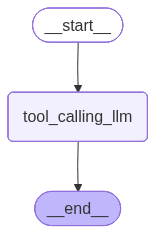

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END


def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()


display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:

messages = graph.invoke({"messages": HumanMessage(content="Greetings, AI! How's the weather on your end?", name="User")})
for m in messages['messages']:
    m.pretty_print() 

================================ Human Message =================================
Name: User

Greetings, AI! How's the weather on your end?
================================== Ai Message ==================================

Greetings! I don’t have a physical “end,” so I don’t experience weather the way you do—but I can certainly look up current conditions anywhere you’d like. Just let me know the city or region you’re curious about!


In [26]:
messages = graph.invoke({"messages": HumanMessage(content="Convert 28 degrees Celsius to Fahrenheit.", name="Scientist")})
for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================
Name: Scientist

Convert 28 degrees Celsius to Fahrenheit.
================================== Ai Message ==================================

I'll help you convert 28 degrees Celsius to Fahrenheit.
Tool Calls:
  convert_celsius_to_fahrenheit (functions.convert_celsius_to_fahrenheit:0)
 Call ID: functions.convert_celsius_to_fahrenheit:0
  Args:
    celsius: 28
